# Projet Fraude bancaire : Exploration et nettoyage des données

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import fastparquet

In [2]:
os.getcwd()

'/home/elisa/Documents/M2_SISE/BigDataMining/Projet_Fraude'

## I. Importation et decription du dataframe avec pandas
La 1956362ieme ligne contient les noms des colonnes en doublons. Nous importons donc le fichier sans cette ligne. 

In [3]:
df = pd.read_table("guillaume.txt", sep=";", header=0, decimal=",", skiprows = [1956361])
df.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [4]:
print("Le fichier contient " + str(df.shape[0]) + " lignes et " + str(df.shape[1]) + " colonnes.")

# Taille 
taille = sys.getsizeof(df)

print("Taille (octets) = " + str(taille))
print("Taille (bits) = " + str(taille/8))

Le fichier contient 4646773 lignes et 23 colonnes.
Taille (octets) = 1514848142
Taille (bits) = 189356017.75


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646773 entries, 0 to 4646772
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisationCheque  int64  
 2   FlagImpaye                int64  
 3   Montant                   float64
 4   DateTransaction           object 
 5   CodeDecision              int64  
 6   VerifianceCPT1            int64  
 7   VerifianceCPT2            int64  
 8   VerifianceCPT3            int64  
 9   D2CB                      int64  
 10  ScoringFP1                float64
 11  ScoringFP2                float64
 12  ScoringFP3                float64
 13  TauxImpNb_RB              float64
 14  TauxImpNB_CPM             float64
 15  EcartNumCheq              int64  
 16  NbrMagasin3J              int64  
 17  DiffDateTr1               float64
 18  DiffDateTr2               float64
 19  DiffDateTr3               float64
 20  CA3TRetMtt              

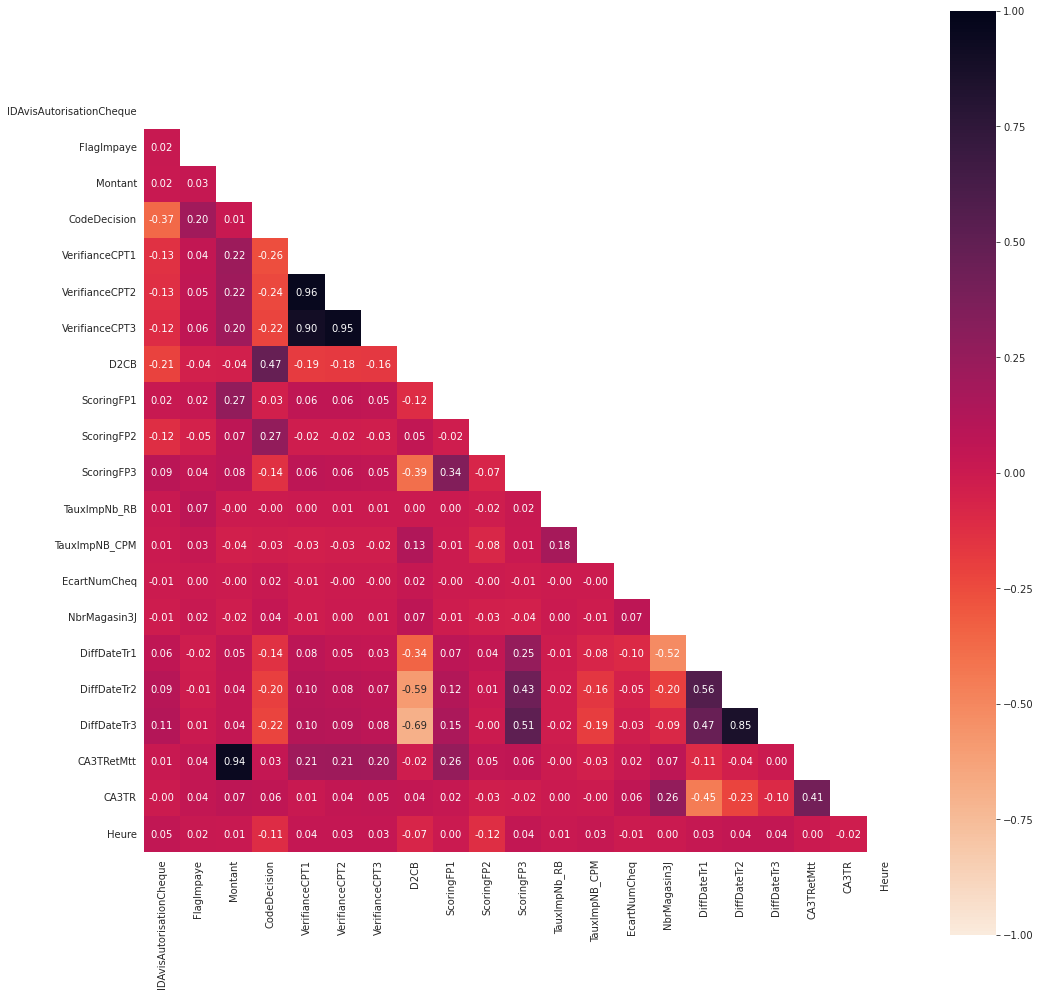

In [6]:
# Matrice de corrélation
corr = df.corr()

# Pour supprimer le côté droit
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# plot
with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(17, 17))

    ax = sns.heatmap(corr, mask=mask, square=True, annot = True, fmt = '.2f', 
                     cmap = "rocket_r", vmin=-1, vmax=1)
    
# Remarques :
# - Les variables VerifianceCPT1, VerifianceCPT2 et VerifianceCPT3 sont très corrélées entre elles.
# - DiffDateTr2 et DiffDateTr3 sont aussi très corrélées.
# - Montant est très corrélée à CA3TRetMtt


## II. Nettoyage du dataframe

### Variable "Heure"
Cette variable fait doublon avec "DateTransaction". Nous décidons donc de la supprimer.

In [7]:
df.drop(["Heure"], axis = "columns", inplace = True)
df.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25


### Variable "DateTransaction" --> "Date" et "Heure"

In [8]:
# Convertir DateTransaction en 2 colonnes : Date et Heure
DateTransaction_temp = df['DateTransaction'].str.split(' ', 1)
df['Date'] = DateTransaction_temp.str[0]
df['Heure'] = DateTransaction_temp.str[1]
# Supprimer la colonne
df.drop(["DateTransaction"], axis = "columns", inplace = True)
df.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,...,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,A013010004908126703060931,78643044,0,20.00,1,0,0,0,551,0.000000,...,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,A013011306908024927155000,78643045,0,20.00,1,0,0,0,551,0.000000,...,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,A013010002908283134592527,78643046,0,57.64,1,0,0,0,549,0.000000,...,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,A011010002908105209831316,78643047,0,54.29,0,1,1,1,267,0.000000,...,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,A013010041908000125652029,78643048,0,26.90,1,0,0,0,549,0.003769,...,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


[Text(0.5, 1.0, 'Répartition des fraudes dans la journée')]

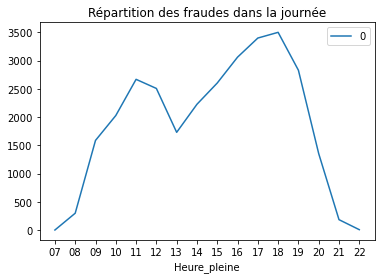

In [9]:
# Création de la variable "Heure_pleine"
df["Heure_pleine"] = df['Heure'].str[:2] 

p = sns.lineplot(data = pd.DataFrame(df[df["FlagImpaye"] == 1].groupby(["Heure_pleine"]).size()))
p.set(title = "Répartition des fraudes dans la journée")

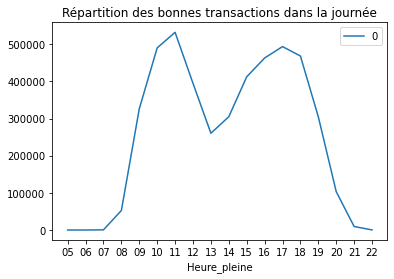

In [10]:
p = sns.lineplot(data = pd.DataFrame(df[df["FlagImpaye"] == 0].groupby(["Heure_pleine"]).size()))
p.set(title = "Répartition des bonnes transactions dans la journée")

# Suppression de la variable "Heure_pleine"
df.drop(["Heure_pleine"], axis = "columns", inplace = True) 

# --> On voit qu'il n'y a pas vraiment d'impact de l'heure dans le refus des transactions. 

### Variables : "ZIBZIN", "IDAvisAutorisationCheque"
Ce sont des variables d'identifiants, elles n'apportenent donc pas d'information pertinante. Nous décidons donc de les supprimer. 

In [11]:
# Supprimer les colonnes : "ZIBZIN", "IDAvisAutorisationCheque"
df.drop(["ZIBZIN", "IDAvisAutorisationCheque"], axis = "columns", inplace = True)
df.head()

,FlagImpaye,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,...,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,0,0,0,551,0.000000,0.000000,0.000000,...,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,0,0,0,551,0.000000,0.000000,0.000000,...,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,0,0,0,549,0.000000,0.000000,0.000000,...,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,1,1,1,267,0.000000,0.000000,0.000000,...,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,0,0,0,549,0.003769,8.586333,0.001192,...,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


### Variable "CodeDecision" 
En observant le dataframe, nous avons remarquer que la variable qualitative "CodeDecision" possède une valeur à 4 alors que dans la description des données, cette variable ne peut prendre que les valeurs 0, 1, 2 ou 3. Nous faisons donc le choix de la retirer du dataframe.

In [12]:
print("Dans le dataframe initial :")
print(df['CodeDecision'].value_counts())
df = df.drop(df[df["CodeDecision"] == 4].index, axis = 0)
print("-------------------------------------------------------")
print("Après suppression de la ligne où 'CodeDecision' = 4 :")
print(df['CodeDecision'].value_counts())

Dans le dataframe initial :
0    3502786
1    1121626
2      19562
3       2798
4          1
Name: CodeDecision, dtype: int64
-------------------------------------------------------
Après suppression de la ligne où 'CodeDecision' = 4 :
0    3502786
1    1121626
2      19562
3       2798
Name: CodeDecision, dtype: int64


In [13]:
# Canger le type de la variable "CodeDecision"
df['CodeDecision'] = df['CodeDecision'].astype('object')

### Variables : "VerifianceCPT1", "VerifianceCPT2", "VerifianceCPT3"
Ces trois variables prennent tout le temps 0 en valeur dans le dataframe de test. Nous décidons donc de les supprimer.

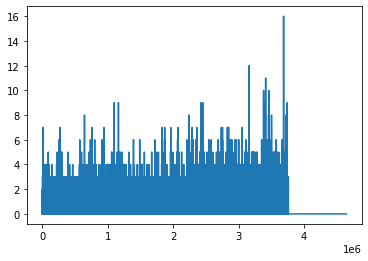

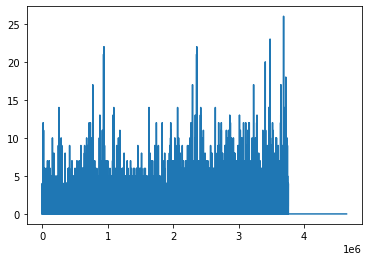

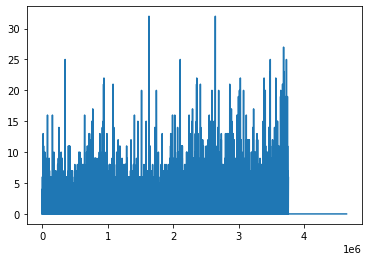

In [14]:
plt.plot(df["VerifianceCPT1"])
plt.show()
plt.plot(df["VerifianceCPT2"])
plt.show()
plt.plot(df["VerifianceCPT3"])
plt.show()

In [15]:
# Supprimer les colonnes : "VerifianceCPT1", "VerifianceCPT2", "VerifianceCPT3"
df.drop(["VerifianceCPT1", "VerifianceCPT2", "VerifianceCPT3"], axis = "columns", inplace = True)
df.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


### Variable "CA3TRetMtt"
Dans 97.5% des données, la variable "CA3TRetMtt" est égale à "Montant" + "CA3TR"

In [16]:
(df["Montant"] + df["CA3TR"] == df["CA3TRetMtt"]).value_counts(normalize=True)

True     0.975499
False    0.024501
dtype: float64

In [17]:
# Suppression de la variable "CA3TRetMtt"
df.drop(["CA3TRetMtt"], axis = "columns", inplace = True) 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4646772 entries, 0 to 4646772
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   FlagImpaye     int64  
 1   Montant        float64
 2   CodeDecision   object 
 3   D2CB           int64  
 4   ScoringFP1     float64
 5   ScoringFP2     float64
 6   ScoringFP3     float64
 7   TauxImpNb_RB   float64
 8   TauxImpNB_CPM  float64
 9   EcartNumCheq   int64  
 10  NbrMagasin3J   int64  
 11  DiffDateTr1    float64
 12  DiffDateTr2    float64
 13  DiffDateTr3    float64
 14  CA3TR          float64
 15  Date           object 
 16  Heure          object 
dtypes: float64(10), int64(4), object(3)
memory usage: 638.1+ MB


## III. Subdivision en apprentissage/test
- dfTrain : du 2017-02-01 au 2017-08-31
- dfTest : du 2017-09-01 au 2017-11-30

In [19]:
dfTrain = df.loc[df['Date'] <= '2017-08-31']
dfTest = df.loc[df['Date'] >= '2017-09-01']
dfTrain.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,2017-02-01,08:13:27


In [20]:
dfTest.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,Date,Heure
3899362,0,60.00,0,302,0.000000,0.000000,0.000000,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,2017-09-01,07:34:17
3899363,0,25.00,0,547,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.000000,4.000000,0.00,2017-09-01,08:06:17
3899364,0,32.00,0,152,0.000000,0.000000,0.000000,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,2017-09-01,08:08:03
3899365,0,20.88,0,393,0.007590,0.182221,0.002092,45.142680,34.118277,4,1,0.573461,0.998206,1.539155,71.51,2017-09-01,08:09:03
3899366,0,20.21,0,152,0.018994,-1.024399,0.005682,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,2017-09-01,08:11:37


In [21]:
# Supprimer les variables "Date" et "Heure"
dfTrain = dfTrain.drop(["Date", "Heure"], axis = "columns")
dfTest = dfTest.drop(["Date", "Heure"], axis = "columns")

## IV. Recodage de la variable "CodeDecision" dans les varaibles explicatives
Rmq : La variable qualitative "CodeDecision" possède les modalités 0, 1, 2 et 3 dans dfTrain et les modalités 0, 2 et 3 dans dfTest.
Notre stratégie est la suivante :
1. Recodage de la variable "CodeDecision" dans les variables explicatives XTrain et XTest.
2. Comme la variable "CodeDecision_1" n'est présente que dans XTrain, elle devient inutile. Nous décidons donc de la supprimer.

In [22]:
# Exposition du problème 
print("Dans le dataframe d'apprentissage :")
print(dfTrain['CodeDecision'].value_counts())
print("-------------------------------------------------------")
print("Dans le dataframe de test :")
print(dfTest['CodeDecision'].value_counts())

Dans le dataframe d'apprentissage :
0    2760391
1    1121626
2      15138
3       2207
Name: CodeDecision, dtype: int64
-------------------------------------------------------
Dans le dataframe de test :
0    742395
2      4424
3       591
Name: CodeDecision, dtype: int64


In [23]:
# 1) Recodage de la variable "CodeDecision" dans les variables explicatives 
dfTrain_ok = pd.get_dummies(dfTrain, prefix=['CodeDecision'])
dfTest_ok = pd.get_dummies(dfTest, prefix=['CodeDecision'])

In [24]:
# 2) Supprimer la variable "CodeDecision_1" de dfTrain
dfTrain_ok = dfTrain_ok.drop(["CodeDecision_1"], axis = "columns")
dfTrain_ok.head()

,FlagImpaye,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
1,0,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0
2,0,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
3,0,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0
4,0,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0


In [25]:
dfTest_ok.head()

,FlagImpaye,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
3899362,0,60.00,302,0.000000,0.000000,0.000000,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0
3899363,0,25.00,547,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0
3899364,0,32.00,152,0.000000,0.000000,0.000000,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0
3899365,0,20.88,393,0.007590,0.182221,0.002092,45.142680,34.118277,4,1,0.573461,0.998206,1.539155,71.51,1,0,0
3899366,0,20.21,152,0.018994,-1.024399,0.005682,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0


## III. Transformation du dataset en dask 

In [26]:
dfTrain_ok_dask = dd.from_pandas(dfTrain_ok, npartitions=20)
print(dfTrain_ok_dask)
print(dfTrain_ok_dask.dtypes)

Dask DataFrame Structure:
               FlagImpaye  Montant   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNb_RB TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr1 DiffDateTr2 DiffDateTr3    CA3TR CodeDecision_0 CodeDecision_2 CodeDecision_3
npartitions=20                                                                                                                                                                                                           
0                   int64  float64  int64    float64    float64    float64      float64       float64        int64        int64     float64     float64     float64  float64          uint8          uint8          uint8
194969                ...      ...    ...        ...        ...        ...          ...           ...          ...          ...         ...         ...         ...      ...            ...            ...            ...
...                   ...      ...    ...        ...        ...        ...          ...           ... 

In [27]:
dfTest_ok_dask = dd.from_pandas(dfTest_ok, npartitions=20)
print(dfTest_ok_dask)
print(dfTest_ok_dask.dtypes)

Dask DataFrame Structure:
               FlagImpaye  Montant   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNb_RB TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr1 DiffDateTr2 DiffDateTr3    CA3TR CodeDecision_0 CodeDecision_2 CodeDecision_3
npartitions=20                                                                                                                                                                                                           
3899362             int64  float64  int64    float64    float64    float64      float64       float64        int64        int64     float64     float64     float64  float64          uint8          uint8          uint8
3936733               ...      ...    ...        ...        ...        ...          ...           ...          ...          ...         ...         ...         ...      ...            ...            ...            ...
...                   ...      ...    ...        ...        ...        ...          ...           ... 

## IV. Convertir et enregistrer le dataset dask au format parquet 
- Le dataframe propre d’apprentissage : dfTrain_parquet
- Le dataframe propre de test : dfTest_parquet

In [28]:
# Le dataframe propre d’apprentissage : dfTrain_parquet
dfTrain_ok_dask.to_parquet('dfTrain_parquet')

In [29]:
# Le dataframe propre de test : dfTest_parquet
dfTest_ok_dask.to_parquet('dfTest_parquet')

## V. Verification du dataset au format parquet 

In [30]:
data = dd.read_parquet('dfTrain_parquet')
print(data)

Dask DataFrame Structure:
               FlagImpaye  Montant   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNb_RB TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr1 DiffDateTr2 DiffDateTr3    CA3TR CodeDecision_0 CodeDecision_2 CodeDecision_3
npartitions=20                                                                                                                                                                                                           
0                   int64  float64  int64    float64    float64    float64      float64       float64        int64        int64     float64     float64     float64  float64          uint8          uint8          uint8
194969                ...      ...    ...        ...        ...        ...          ...           ...          ...          ...         ...         ...         ...      ...            ...            ...            ...
...                   ...      ...    ...        ...        ...        ...          ...           ... 

In [31]:
data.head()

,FlagImpaye,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
1,0,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0
2,0,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
3,0,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0
4,0,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0


In [32]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, FlagImpaye to CodeDecision_3
dtypes: float64(10), int64(4), uint8(3)

## VI. Sur-échantillonnage et sous-échantillonnage du dataframe d'apprentissage
Nous remarquons que dans notre dataframe d'apprentissage, les fraudes ne représentent que 0.006007% des observations. 

In [33]:
# Séparation de XTrain et yTrain 
XTrain = dfTrain_ok_dask.drop(["FlagImpaye"], axis = "columns")
yTrain = dfTrain_ok_dask["FlagImpaye"]

In [34]:
# Affichage du nombre d'observation Fraude/Non fraude
print(dfTrain_ok_dask['FlagImpaye'].value_counts(normalize = True).compute())

0    0.993993
1    0.006007
Name: FlagImpaye, dtype: float64


In [35]:
print("Nombre de lignes dans le dataframe d'apprentissage = " + str(dfTrain_ok_dask.shape[0].compute()))

Nombre de lignes dans le dataframe d'apprentissage = 3899362


### A) Sur-échantillonnage : Méthode SMOTE pour agrandir la classe minoritaire à 50%
SMOTE est une méthode de sur-échantillonage qui permet de générer synthétiquement de nouvelles instances de la classe minoritaire en utilisant les instances existantes.

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0, n_jobs = -1) 

XTrain_SMOTE, yTrain_SMOTE = smote.fit_resample(XTrain, yTrain)

In [37]:
XTrain_SMOTE.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0


In [38]:
print("Nombre de lignes (avec la méthode SMOTE) = " + str(XTrain_SMOTE.shape[0]))

Nombre de lignes (avec la méthode SMOTE) = 7751880


In [39]:
# Affichage du nombre d'observation Fraude/Non fraude
print(yTrain_SMOTE.value_counts(normalize = True))

0    0.5
1    0.5
Name: FlagImpaye, dtype: float64


In [40]:
dfTrain_SMOTE = XTrain_SMOTE
dfTrain_SMOTE["FlagImpaye"] = yTrain_SMOTE
dfTrain_SMOTE.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3,FlagImpaye
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0,0


### Convertir et enregister au format parquet
- Le dataframe propre d’apprentissage avec sur-échantillonnage : dfTrain_SMOTE_parquet

In [41]:
dfTrain_SMOTE_dask = dd.from_pandas(dfTrain_SMOTE, npartitions=20)
print(dfTrain_SMOTE_dask)

Dask DataFrame Structure:
                Montant   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNb_RB TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr1 DiffDateTr2 DiffDateTr3    CA3TR CodeDecision_0 CodeDecision_2 CodeDecision_3 FlagImpaye
npartitions=20                                                                                                                                                                                                           
0               float64  int64    float64    float64    float64      float64       float64        int64        int64     float64     float64     float64  float64          uint8          uint8          uint8      int64
387594              ...    ...        ...        ...        ...          ...           ...          ...          ...         ...         ...         ...      ...            ...            ...            ...        ...
...                 ...    ...        ...        ...        ...          ...           ...          ..

In [42]:
# Le dataframe propre d’apprentissage avec sur-échantillonnage : dfTrain_SMOTE_parquet
dfTrain_SMOTE_dask.to_parquet('dfTrain_SMOTE_parquet')

### B) Sous-échantillonnage : Méthode RandomUnderSampler pour diminuer la classe majoritaire à 50%
- RandomUnderSampler est une méthode de sous-échantillonage qui permet de choisissant des échantillons de la classe majoritaire au hasard avec ou sans remise. Ici, le tirage est sans remise par défaut.

In [44]:
from imblearn.under_sampling import RandomUnderSampler

Under = RandomUnderSampler(random_state = 0) 

XTrain_Under, yTrain_Under = Under.fit_resample(XTrain, yTrain)

In [45]:
print("Nombre de lignes (avec la méthode RandomUnderSampler) = " + str(XTrain_Under.shape[0]))

Nombre de lignes (avec la méthode RandomUnderSampler) = 46844


In [46]:
# Affichage du nombre d'observation Fraude/Non fraude
print(yTrain_Under.value_counts(normalize = True))

0    0.5
1    0.5
Name: FlagImpaye, dtype: float64


In [47]:
dfTrain_Under = XTrain_Under
dfTrain_Under["FlagImpaye"] = yTrain_Under
dfTrain_Under.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3,FlagImpaye
0,16.79,551,0.003809,8.035647,0.001119,38.992084,44.073599,0,1,4.0,4.0,4.0,0.0,0,0,0,0
1,37.09,249,0.029791,11.482898,0.002173,13.370176,31.417268,0,1,4.0,4.0,4.0,0.0,1,0,0,0
2,15.00,174,0.000000,0.000000,0.000000,12.873527,28.028904,0,1,4.0,4.0,4.0,0.0,1,0,0,0
3,357.65,442,0.016514,-0.274170,0.001798,55.774278,43.897362,0,1,4.0,4.0,4.0,0.0,1,0,0,0
4,151.93,504,0.027404,-13.830572,0.002032,48.844716,52.076034,0,1,4.0,4.0,4.0,0.0,1,0,0,0


### Convertir et enregister au format parquet
- Le dataframe propre d’apprentissage avec sous-échantillonnage : dfTrain_Under_parquet

In [48]:
dfTrain_Under_dask = dd.from_pandas(dfTrain_Under, npartitions=20)
print(dfTrain_Under_dask)

Dask DataFrame Structure:
                Montant   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNb_RB TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr1 DiffDateTr2 DiffDateTr3    CA3TR CodeDecision_0 CodeDecision_2 CodeDecision_3 FlagImpaye
npartitions=20                                                                                                                                                                                                           
0               float64  int64    float64    float64    float64      float64       float64        int64        int64     float64     float64     float64  float64          uint8          uint8          uint8      int64
2343                ...    ...        ...        ...        ...          ...           ...          ...          ...         ...         ...         ...      ...            ...            ...            ...        ...
...                 ...    ...        ...        ...        ...          ...           ...          ..

In [49]:
# Le dataframe propre d’apprentissage avec sur-échantillonnage : dfTrain_SMOTE_parquet
dfTrain_Under_dask.to_parquet('dfTrain_Under_parquet')